In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import json

with open("user-wallet-transactions.json", 'r') as f:
    raw_data = json.load(f)

# Clean + flatten relevant fields
clean_data = []
for tx in raw_data:
    try:
        wallet = tx['userWallet']
        action = tx['action'].lower()
        timestamp = datetime.utcfromtimestamp(tx['timestamp'])
        raw_amount = float(tx['actionData'].get('amount', 0))
        price = float(tx['actionData'].get('assetPriceUSD', 0))
        amount_usd = (raw_amount / 1e6) * price if price else 0

        clean_data.append({
            'wallet': wallet,
            'action': action,
            'timestamp': timestamp,
            'amount_usd': amount_usd
        })
    except:
        continue

df = pd.DataFrame(clean_data)
df.head()


C:\Users\Surendra reddy\AppData\Local\Temp\ipykernel_3628\1264696330.py:12: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  timestamp = datetime.utcfromtimestamp(tx['timestamp'])


,wallet,action,timestamp,amount_usd
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,2021-08-17 05:29:26,1.987664e+03
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,2021-05-20 15:36:53,2.856945e+14
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-24 09:28:33,9.223773e+08
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-31 23:15:18,4.229933e+09
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,2021-04-19 15:25:07,5.026161e-01


In [ ]:
# with this i can understand the what are the max and min actions user are taking 
df['action'].value_counts()

action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64

In [4]:
features = df.groupby('wallet').agg(
    deposit_count=('action', lambda x: (x == 'deposit').sum()),
    redeem_count=('action', lambda x: (x == 'redeemunderlying').sum()),
    borrow_count=('action', lambda x: (x == 'borrow').sum()),
    repay_count=('action', lambda x: (x == 'repay').sum()),
    liquidation_count=('action', lambda x: (x == 'liquidationcall').sum()),
    total_deposit_usd=('amount_usd', lambda x: x[df.loc[x.index, 'action'] == 'deposit'].sum()),
    total_borrow_usd=('amount_usd', lambda x: x[df.loc[x.index, 'action'] == 'borrow'].sum()),
    total_repay_usd=('amount_usd', lambda x: x[df.loc[x.index, 'action'] == 'repay'].sum()),
    total_redeem_usd=('amount_usd', lambda x: x[df.loc[x.index, 'action'] == 'redeemunderlying'].sum()),
    active_days=('timestamp', lambda x: x.dt.date.nunique())
).reset_index()

# Add derived feature: repay ratio
features['repay_ratio'] = features['total_repay_usd'] / features['total_borrow_usd'].replace(0, 1)

# View the result
features.head()


,wallet,deposit_count,redeem_count,borrow_count,repay_count,liquidation_count,total_deposit_usd,total_borrow_usd,total_repay_usd,total_redeem_usd,active_days,repay_ratio
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,0,0,0,0,1.987664e+03,0.000000e+00,0.000000,0.000000e+00,1,0.000000e+00
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,0,0,0,0,2.856945e+14,0.000000e+00,0.000000,0.000000e+00,1,0.000000e+00
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,0,0,0,0,5.152311e+09,0.000000e+00,0.000000,0.000000e+00,2,0.000000e+00
3,0x0000000000e189dd664b9ab08a33c4839953852c,0,17,0,0,0,0.000000e+00,0.000000e+00,0.000000,9.803600e+14,8,0.000000e+00
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,250,130,15,4,0,2.065773e+17,6.029762e+16,70150.263791,1.128745e+17,104,1.163400e-12


In [5]:
def calculate_credit_score(row):
    score = 0

    # Repay Ratio (35% weight → max 350 pts)
    repay_ratio = min(row['repay_ratio'], 1.0)  # cap at 1.0
    score += repay_ratio * 350

    # Borrow Health (30% weight → max 300 pts)
    if row['borrow_count'] > 0:
        net_diff = row['total_borrow_usd'] - row['total_repay_usd']
        borrow_health = max(0, 1 - (net_diff / row['total_borrow_usd']))  # closer to 1 is better
        score += borrow_health * 300

    # Active Days (15% weight → max 150 pts)
    if row['active_days'] >= 15:
        score += 150
    elif row['active_days'] >= 5:
        score += 100
    elif row['active_days'] >= 3:
        score += 50
    else:
        score += 0  # inactive = no points

    # Deposit Behavior (10% weight → max 100 pts)
    if row['deposit_count'] > 0:
        score += min(row['deposit_count'] * 10, 100)  # max 100 pts

    # Liquidation Penalty (‒200 per event)
    score -= row['liquidation_count'] * 200

    # Pattern Penalty: borrowed but no repay
    if row['borrow_count'] > 0 and row['repay_count'] == 0:
        score -= 100

    # Final clipping to 0–1000
    return int(np.clip(score, 0, 1000))

# Apply to all wallets
features['credit_score'] = features.apply(calculate_credit_score, axis=1)
features[['wallet', 'credit_score']].head()



,wallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,10
1,0x000000000051d07a4fb3bd10121a343d85818da6,10
2,0x000000000096026fb41fc39f9875d164bd82e2dc,20
3,0x0000000000e189dd664b9ab08a33c4839953852c,100
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,250


C:\Users\Surendra reddy\AppData\Local\Temp\ipykernel_3628\4107262766.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=features, x='score_range', palette='viridis')


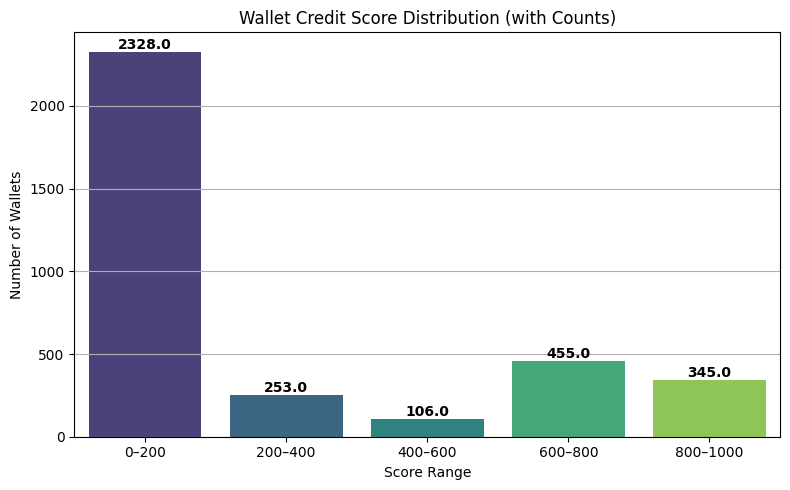

In [6]:
# Define bins and labels
bins = [0, 200, 400, 600, 800, 1000]
labels = ["0–200", "200–400", "400–600", "600–800", "800–1000"]

# Apply binning
features['score_range'] = pd.cut(features['credit_score'], bins=bins, labels=labels, right=False)

# Plot with count annotations
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=features, x='score_range', palette='viridis')

# Annotate each bar with its count
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Wallet Credit Score Distribution (with Counts)")
plt.xlabel("Score Range")
plt.ylabel("Number of Wallets")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [13]:
# Select only wallet and credit score
score_output = features[['wallet', 'credit_score']]

# Convert to a list of dicts
score_list = score_output.to_dict(orient='records')

# Save to JSON file
import json
with open('wallet_credit_scores.json', 'w') as f:
    json.dump(score_list, f, indent=2)

print("Saved as wallet_credit_scores.json")


Saved as wallet_credit_scores.json


In [8]:
from sklearn.model_selection import train_test_split

# Define X and y
X = features.drop(columns=['wallet', 'credit_score', 'score_range'])  # input features
y = features['credit_score']  # target label

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
from xgboost import XGBRegressor

# Create and train the model
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [10]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 3.07
R² Score: 0.9992


In [11]:
# Create a DataFrame to compare actual and predicted
results = pd.DataFrame({
    'wallet': features['wallet'],
    'actual_score': y,
    'predicted_score': model.predict(X).round(2)
})

results.head(10)  # Show first 10 rows


,wallet,actual_score,predicted_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,10,10.060000
1,0x000000000051d07a4fb3bd10121a343d85818da6,10,10.060000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,20,19.760000
3,0x0000000000e189dd664b9ab08a33c4839953852c,100,100.989998
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,250,249.789993
5,0x000000000a38444e0a6e37d3b630d7e855a7cb13,870,870.250000
6,0x000000003853fcedcd0355fec98ca3192833f00b,130,112.919998
7,0x000000003ce0cf2c037493b1dc087204bd7f713e,251,258.420013
8,0x000000007858e6f2668e1e06111cfa24403a5466,10,10.060000
9,0x00000001a0f57e850c9db68b4a9bc34677437c5c,10,10.060000
